# Binomial Logistic Regression on the Liar Dataset
** Names: ** Barbara, Eva & Joyce
<br><br>
In this notebook, you will find a binomial regression done on a reduced part of the training set (i.e. we took out all the statements that were not labeled 'false' or 'true'). We created this notebook to get ourself acquainted with how  logistic regression performs on our dataset. 

### Index
1. ** LR with `Count Vectorizer` **
    - normal
    - with SVD
    
2. ** LR with `TF-IDF Vectorizer` **
    - normal 
    - with SVD
    
3. ** Applying more filtering ** (stopword & digit removal, lemmatization) 
4. ** Implementing more features ** (sentiment & political preference)
5. ** Testing on a different dataset ** 
6. ** Final results & remarks ** 

In [25]:
# all you need for this notebook
import pandas as pd
import numpy as np
import sklearn

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import decomposition

from collections import OrderedDict

import nltk
from nltk.corpus import stopwords
import string

import matplotlib.pyplot as plt

In [4]:
# create df of all the data
df_liar = pd.read_csv("train.tsv", encoding="utf8", sep="\t", names=["id", "truth-value", 
                                                                     "text", "topic", "name", "job", 
                                                                     "state", "politics", "count1", "count2", 
                                                                     "count3", "count4", "count5", "context"])

df_liar.head(3)

,id,truth-value,text,topic,name,job,state,politics,count1,count2,count3,count4,count5,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver


In [5]:
# classification formula to take out only statements labeled with 'true' or 'false'
def classify(text):
    if text == "false":
        return 0
    elif text == "true":
        return 1 
    else: 
        return -1 

In [6]:
# add the class of truth-values
df_liar["class"] = df_liar["truth-value"].apply(classify) 

In [7]:
# reduce the dataset to only true/false sentences
df_reduced = df_liar[df_liar["class"] != -1]
print(df_reduced.shape)
df_reduced.head(3)

(3671, 15)


,id,truth-value,text,topic,name,job,state,politics,count1,count2,count3,count4,count5,context,class
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,0
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,0
5,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,1


## 1. Using CountVectorizer
First we will try the Logistic Regression using `CountVectorizer()`, which converts the text to a matrix in which each token (here: each word of the full vocabulary of our statements) is represented with counts that tell how often the token occurs in each statement. 

In [8]:
count_vect = CountVectorizer()

# training set
X_train = count_vect.fit(df_reduced.text)
X_train = count_vect.transform(df_reduced.text)
X_train.shape

(3671, 7451)

In [9]:
# subtract the classes
y_train = df_reduced["class"].values

In [10]:
logreg = LogisticRegression(solver='lbfgs')

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(X_train, y_train)

/Applications/Anaconda/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
# create df of the test data
df_liar_test = pd.read_csv("test.tsv", encoding="utf8", sep="\t", names=["id", "truth-value", 
                                                                     "text", "topic", "name", "job", 
                                                                     "state", "politics", "count1", "count2", 
                                                                     "count3", "count4", "count5", "context"])
df_liar_test["class"] = df_liar_test["truth-value"].apply(classify)
df_test_reduced = df_liar_test[df_liar_test["class"] != -1]

# transform the test data to the right format, aligning with the training data 
# (so that it has the size of the vocab of the training set)
X_test = count_vect.transform(df_test_reduced.text) 
y_test = df_test_reduced["class"].values
X_test.shape

(457, 7451)

In [12]:
# we could try to evaluate the model
logreg.fit(X_train, y_train)
y_hat_test = logreg.predict(X_test)

# evaluate using accuracy: proportion of correctly predicted over total
print(accuracy_score(y_test, y_hat_test))
print(accuracy_score(y_test, y_hat_test, normalize=False))

0.599562363239
274


/Applications/Anaconda/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## Comments
> This is not super high accuracy, but it is better than the multinomal regression we experimented with in update 1 (which was around 0.3). However, we don't really expect a high accuracy, since our dataset is not very dense, so this is already better than we expected! 

## Feature importance
We created a dictionary of all the features and their weighted importance, to check which features are the most important in the regression.

In [178]:
# this prints out all the coefficients (which is in fact all the vocabulary of the training set)
print(logreg.coef_)
print(logreg.coef_.shape)

[[-0.17203638 -0.27699619  0.05011177 ..., -0.15039476  0.27433863
   0.47206197]]
(1, 7451)


In [179]:
# create a dictionary of all coefficients and their weights from the logistic regression
coef_dict = dict()
for n, key in enumerate(count_vect.vocabulary_.keys()):
    coef_dict[key] = logreg.coef_[0][n] 

In [191]:
# print some scores
for x in list(coef_dict)[0:8]:
    print (x, ":", coef_dict[x])

says : -0.172036379023
the : -0.27699619287
annies : 0.0501117682387
list : 0.149425389135
political : 0.117164536027
group : -0.092538451089
supports : 0.00853503997909
third : 0.134349522517


In [13]:
# ordering
ordered_coefs = [(k, coef_dict[k]) for k in sorted(coef_dict, key=coef_dict.get, reverse=True)]

In [14]:
# 10 highest weighted coefficients:
ordered_coefs[0:10]

[('opposes', 1.2852508564154546),
 ('scanners', 1.2302072443718222),
 ('duel', 1.223908577820521),
 ('democrats', 1.2135750192948989),
 ('dramatically', 1.1738511525095916),
 ('except', 1.1639518946957186),
 ('protects', 1.1618225704045153),
 ('predecessor', 1.1582500993003202),
 ('176', 1.1460457212623074),
 ('fiduciary', 1.133202658098218)]

In [15]:
# 10 lowest weighted coefficients:
ordered_coefs[-10:-1]

[('answer', -1.0141049421385862),
 ('arm', -1.0344518907635407),
 ('sunset', -1.0349690821953719),
 ('1994', -1.0363564779213954),
 ('steroids', -1.0501622342165082),
 ('specter', -1.0730122253388568),
 ('canal', -1.1522027240337045),
 ('alligator', -1.2245222947742149),
 ('stopping', -1.2934142876362542)]

### Comments
> As a result, the highest coefficients are the most important in determining a true statement, whereas the lowest coefficients are the most important in determining a false statement. 


> However, our training data is super sparse, and therefore these words might not be the best indicators of fake/true news statements. For example, the word 'scanners' is a highly neutral word, and we doubt whether it would be used relatively often in fake news. Same thing for the number '176'...

## Dimensionality reduction

We will now perform dimensionality reduction, to check whether our model performs better when it's inputted a smaller dimensional matrix. We will compare the different reduced models by their accuracy. For the dimensionality reduction, we used the Singular Value Decomposition method described in Lab 8 (Vector Semantics). 

In [204]:
# for them to fit in the SVD model, they will have to be converted to numpy matrices first
# converting X_train to a matrix
new_train = np.empty([3671, 7451])
array_X_train = X_train.toarray()

for n in range(3671):
    new_train[n] = array_X_train[n]

# converting X_test to a matrix
new_test = np.empty([457, 7451])
array_X_test = X_test.toarray()

for n in range(457):
    new_test[n] = array_X_test[n]

In [80]:
print(new_train.shape, new_test.shape)

(3671, 7451) (457, 7451)


In [110]:
# picking the different dimensions
dimensions1 = 50
dimensions2 = 100
dimensions3 = 300
dimensions4 = 400

In [111]:
# 50 dimensions SVD
train_SVD50Mat = decomposition.TruncatedSVD(n_components = dimensions1, algorithm = "arpack").fit_transform(new_train)
test_SVD50Mat = decomposition.TruncatedSVD(n_components = dimensions1, algorithm = "arpack").fit_transform(new_test)

In [112]:
train_SVD50Mat.shape

(3671, 50)

In [113]:
# 100 dimensions SVD
train_SVD100Mat = decomposition.TruncatedSVD(n_components = dimensions2, algorithm ="arpack").fit_transform(new_train)
test_SVD100Mat = decomposition.TruncatedSVD(n_components = dimensions2, algorithm = "arpack").fit_transform(new_test)

In [114]:
# 300 dimensions SVD
train_SVD300Mat = decomposition.TruncatedSVD(n_components = dimensions3, algorithm = "arpack").fit_transform(new_train)
test_SVD300Mat = decomposition.TruncatedSVD(n_components = dimensions3, algorithm = "arpack").fit_transform(new_test)

In [115]:
# 400 dimensions SVD
train_SVD400Mat = decomposition.TruncatedSVD(n_components = dimensions4, algorithm ="arpack").fit_transform(new_train)
test_SVD400Mat = decomposition.TruncatedSVD(n_components = dimensions4, algorithm = "arpack").fit_transform(new_test)

In [116]:
# evaluating 50 dimensions SVD model
logreg.fit(train_SVD50Mat, y_train)
y_hat_test_SVD = logreg.predict(test_SVD50Mat)

# evaluate using accuracy: proportion of correctly predicted over total
print(accuracy_score(y_test, y_hat_test_SVD))
print(accuracy_score(y_test, y_hat_test_SVD, normalize=False))

0.492341356674
225


In [117]:
# evaluating 100 dimensions SVD model
logreg.fit(train_SVD100Mat, y_train)
y_hat_test_SVD100 = logreg.predict(test_SVD100Mat)

# evaluate using accuracy: proportion of correctly predicted over total
print(accuracy_score(y_test, y_hat_test_SVD100))
print(accuracy_score(y_test, y_hat_test_SVD100, normalize=False))

0.474835886214
217


In [118]:
# evaluating 300 dimensions SVD model
logreg.fit(train_SVD300Mat, y_train)
y_hat_test_SVD300 = logreg.predict(test_SVD300Mat)

# evaluate using accuracy: proportion of correctly predicted over total
print(accuracy_score(y_test, y_hat_test_SVD300))
print(accuracy_score(y_test, y_hat_test_SVD300, normalize=False))

0.487964989059
223


In [119]:
# evaluating 400 dimensions SVD model
logreg.fit(train_SVD400Mat, y_train)
y_hat_test_SVD400 = logreg.predict(test_SVD400Mat)

# evaluate using accuracy: proportion of correctly predicted over total
print(accuracy_score(y_test, y_hat_test_SVD400))
print(accuracy_score(y_test, y_hat_test_SVD400, normalize=False))

0.492341356674
225


### Results

Model | Accuracy 
--- | --- 
nonSVD | 0.59956
SVD50 | 0.49234
SVD100 | 0.47483
SVD300 | 0.48796
SVD400 | 0.49234

### Comments
> As you can see in the table above, the higher the dimension, the higher the accuracy. The model that works the best is the one in which the dimensions have not been reduced. We did not expect this, because since we're using a sparse vector, we thought the reduction might help out to make the regression easier. 

## 2. Using TfidfVectorizer
Instead of the `CountVectorizer()`, we now tried the Logistic Regression using the `TfidfVectorizer()`. This vectorizer converts the statements to a matrix of TF-IDF features. We expect this might perform better, since the matrix contains relative counts, and serves less importance to the tokens that appear a lot.   

In [13]:
tfidf_vect = TfidfVectorizer()

# creating the training vector
X_train_tfidf = tfidf_vect.fit(df_reduced.text)
X_train_tfidf = tfidf_vect.transform(df_reduced.text)
X_train_tfidf.shape

(3671, 7451)

In [14]:
# fitting the training data
logreg.fit(X_train_tfidf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
# creating the test vector
X_test_tfidf = tfidf_vect.transform(df_test_reduced.text) 
X_test_tfidf.shape

(457, 7451)

In [16]:
# evaluating the tfidf model
logreg.fit(X_train_tfidf, y_train)
y_hat_test = logreg.predict(X_test_tfidf)

# evaluate using accuracy: proportion of correctly predicted over total
print(accuracy_score(y_test, y_hat_test))
print(accuracy_score(y_test, y_hat_test, normalize=False))

0.628008752735
287


### Comments
> This gives about 0.03 higher accuracy than the regression using `CountVectorizer`. This is not a super significant difference, but it at least suggests that we could probably better usse the `TfifVectorizer` for our multinomial regression too. 

## Dimensionality reduction
Again, we'll perform Singular Value Decomposition to see whether the reduction of dimensions will change the outcome of the regression. 

In [205]:
# converting train to a matrix
new_train_tfidf = np.empty([3671, 7451])
array_X_train_tfidf = X_train_tfidf.toarray()

for n in range(3671):
    new_train_tfidf[n] = array_X_train_tfidf[n]

# converting test to a matrix
new_test_tfidf = np.empty([457, 7451])
array_X_test_tfidf = X_test_tfidf.toarray()

for n in range(457):
    new_test_tfidf[n] = array_X_test_tfidf[n]

In [100]:
# dimensions
dimensions1 = 50
dimensions2 = 100
dimensions3 = 300
dimensions4 = 400

In [102]:
# 50 dimensions
train_SVD50Mat_tfidf = decomposition.TruncatedSVD(n_components = dimensions1, algorithm = "arpack").fit_transform(new_train_tfidf)
test_SVD50Mat_tfidf = decomposition.TruncatedSVD(n_components = dimensions1, algorithm = "arpack").fit_transform(new_test_tfidf)

In [103]:
# 100 dimensions
train_SVD100Mat_tfidf = decomposition.TruncatedSVD(n_components = dimensions2, algorithm = "arpack").fit_transform(new_train_tfidf)
test_SVD100Mat_tfidf = decomposition.TruncatedSVD(n_components = dimensions2, algorithm = "arpack").fit_transform(new_test_tfidf)

In [104]:
# 300 dimensions 
train_SVD300Mat_tfidf = decomposition.TruncatedSVD(n_components = dimensions3, algorithm = "arpack").fit_transform(new_train_tfidf)
test_SVD300Mat_tfidf = decomposition.TruncatedSVD(n_components = dimensions3, algorithm = "arpack").fit_transform(new_test_tfidf)

In [105]:
# 400 dimensions 
train_SVD400Mat_tfidf = decomposition.TruncatedSVD(n_components = dimensions4, algorithm = "arpack").fit_transform(new_train_tfidf)
test_SVD400Mat_tfidf = decomposition.TruncatedSVD(n_components = dimensions4, algorithm = "arpack").fit_transform(new_test_tfidf)

In [106]:
# evaluating 50 dimensions tfidf model
logreg.fit(train_SVD50Mat_tfidf, y_train)
y_hat_test = logreg.predict(test_SVD50Mat_tfidf)

# evaluate using accuracy: proportion of correctly predicted over total
print(accuracy_score(y_test, y_hat_test))
print(accuracy_score(y_test, y_hat_test, normalize=False))

0.544857768053
249


In [107]:
# evaluating 100 dimensions tfidf model
logreg.fit(train_SVD100Mat_tfidf, y_train)
y_hat_test = logreg.predict(test_SVD100Mat_tfidf)

# evaluate using accuracy: proportion of correctly predicted over total
print(accuracy_score(y_test, y_hat_test))
print(accuracy_score(y_test, y_hat_test, normalize=False))

0.584245076586
267


In [108]:
# evaluating 300 dimensions tfidf model
logreg.fit(train_SVD300Mat_tfidf, y_train)
y_hat_test = logreg.predict(test_SVD300Mat_tfidf)

# evaluate using accuracy: proportion of correctly predicted over total
print(accuracy_score(y_test, y_hat_test))
print(accuracy_score(y_test, y_hat_test, normalize=False))

0.599562363239
274


In [109]:
# evaluating 400 dimensions tfidf model
logreg.fit(train_SVD400Mat_tfidf, y_train)
y_hat_test = logreg.predict(test_SVD400Mat_tfidf)

# evaluate using accuracy: proportion of correctly predicted over total
print(accuracy_score(y_test, y_hat_test))
print(accuracy_score(y_test, y_hat_test, normalize=False))

0.599562363239
274


### Results 
Model | Accuracy 
--- | --- 
nonSVD | 0.62801
SVD50 | 0.54486
SVD100 | 0.58425
SVD300 | 0.59956
SVD400 | 0.59956
### Comments
> As you can see in the table above, there is again better accuracy when the dimensions get higher. Furthermore, all of the different models perform better than their significances of the `CountVectorizer()` models. Also, the SVD300 and SVD400 perform exactly the same as the best `CountVectorizer()` model. Finally, our advise for the multinomial regression would be to use the nonSVD TF-IDF model.

# 3. Filtering out stopwords
Here we check whether filtering out stopwords & digits and applying lemmatization will better the accuracy of our model. We suppose this might work better, since the stopwords are probably not significant in determining the fakeness of a statement. This also hold for digits. Furthermore, applying lemmatization might make reduce the model's vocabulary and make it easier.  

In [17]:
# preprocessing function to lemmatize and to filter out unimportant words. 
def filtering(text):
    lostrings = text.split(' ')
    new_lostrings = []
    for word in lostrings:
        word = nltk.WordNetLemmatizer().lemmatize(
                word.translate(str.maketrans('', '', string.punctuation)).lower()) # remove punctuation & lemmatize
        if word not in stopwords.words('english') and not word.isdigit(): # remove stopwords & digits
            new_lostrings.append(word)
    return ' '.join(new_lostrings)

In [18]:
# let's check if it works
filtering("Hello, it is a nice and warm and chill day today, let's go and take our 2 bikes out for a ride!")

'hello nice warm chill day today let go take bike ride'

In [19]:
# applying it to the statements of the training set
df_reduced["filteredtext"] = df_reduced["text"].apply(filtering)

/Applications/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
# applying it to the statements of the test set
df_test_reduced["filteredtext"] = df_test_reduced["text"].apply(filtering)

/Applications/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
# show the df to see if it works
df_reduced.head(1)

,id,truth-value,text,topic,name,job,state,politics,count1,count2,count3,count4,count5,context,class,filteredtext
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,0,say annies list political group support thirdt...


In [22]:
tfidf_vect = TfidfVectorizer()

# creating the training vector
X_train_filter = tfidf_vect.fit(df_reduced.filteredtext)
X_train_filter = tfidf_vect.transform(df_reduced.filteredtext)

# creating the test vector
X_test_filter = tfidf_vect.transform(df_test_reduced.filteredtext) 

print(X_train_filter.shape, X_test_filter.shape)

(3671, 6589) (457, 6589)


In [23]:
# evaluating the filtered tfidf model
logreg.fit(X_train_filter, y_train)
y_hat_test = logreg.predict(X_test_filter)

# evaluate using accuracy: proportion of correctly predicted over total
print(accuracy_score(y_test, y_hat_test))
print(accuracy_score(y_test, y_hat_test, normalize=False))

0.597374179431
273


### Comments
> After filtering, the vocabulary has been reduced by almost 1000 words (from 7451 to 6589). However, the model does not really work any better than our normal tfidf model (0.597 vs. 0.628), so counterintuitively, filtering shows not to be important when classifying fake news statements...

# 4. New features: sentiment & poltical preference
Here, we will check whether the model works better if we were to give each sentence a sentiment score, and a political score. More on this progress is described in the `Multinomial-LR-TFIDF` notebook. 

In [192]:
# opening the dataset with sentiment scores
df_liar_sentiment = pd.read_csv("sentiment_train.csv", encoding="utf8", sep=",")

In [197]:
# we'll only focus on the 3 most occuring political preferences
politics = dict({"republican": 0, "democrat" : 1, "none" : 2})

# classification formula for political background
def classify_politics(text):
    if text not in politics.keys(): 
        return -1
    else:
        return politics[text]

# add this new class of politic scores
df_liar_sentiment["political-score"] = df_liar_sentiment["politics"].apply(classify_politics)
# also add truth scores
df_liar_sentiment["truth-score"] = df_liar_sentiment["truth-value"].apply(classify) 
# remove the ones we don't want
df_liar_sentiment = df_liar_sentiment[df_liar_sentiment["political-score"] != -1]

In [198]:
df_liar_sentiment.head(1)

,id,truth-value,text,topic,name,job,state,politics,count1,count2,count3,count4,count5,context,pos-sentiment,neg-sentiment,political-score,truth-score
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,0.007972,0.012908,0,0


In [201]:
# opening the test set
df_test_sent = pd.read_csv("sentiment_test.csv", encoding="utf8", sep=",", names=["id", "truth-value", 
                                                                     "text", "topic", "name", "job", 
                                                                     "state", "politics", "count1", "count2", 
                                                                     "count3", "count4", "count5", "context", 
                                                                                        "pos-sentiment", "neg-sentiment"])
df_test_sent["truth-score"] = df_test_sent["truth-value"].apply(classify)
df_test_sent["political-score"] = df_test_sent["politics"].apply(classify_politics)

df_test_sent = df_test_sent[df_test_sent["political-score"] != -1]

In [210]:
# the shapes of the matrices created for SVD
print(new_train_tfidf.shape, new_test_tfidf.shape)

(3671, 7451) (457, 7451)


In [213]:
# we need to add 3 new columns to the matrices, which we already created for the SVD 
# (new_train_tfidf & new_test_tfidf) : one column for the positive sentiment score, 
# one column for the negative score and one column for the political score. 
X_train_sent = np.empty([3671, 7454])

for n in range(3671):
    pos = df_liar_sentiment["pos-sentiment"].values[n]
    neg = df_liar_sentiment["neg-sentiment"].values[n]
    pol = df_liar_sentiment["political-score"].values[n]
    X_train_sent[n] = np.append(new_train_tfidf[n], [pos, neg, pol])

print(X_train_sent)   

[[ 0.          0.          0.         ...,  0.00797194  0.01290816  0.        ]
 [ 0.          0.          0.         ...,  0.01148072  0.0142225   1.        ]
 [ 0.          0.          0.         ...,  0.00925808  0.01196854  1.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.01047535  0.01883803  0.        ]
 [ 0.          0.          0.         ...,  0.00801672  0.01683131  0.        ]
 [ 0.          0.          0.         ...,  0.01071429  0.01392857  0.        ]]


In [215]:
# we also need to do this for the test set.
X_test_sent = np.empty([457, 7454])

for n in range(457):
    pos = df_liar_sentiment["pos-sentiment"].values[n]
    neg = df_liar_sentiment["neg-sentiment"].values[n]
    pol = df_liar_sentiment["political-score"].values[n]
    X_test_sent[n] = np.append(new_test_tfidf[n], [pos, neg, pol])

print(X_test_sent) 

[[ 0.          0.          0.         ...,  0.00797194  0.01290816  0.        ]
 [ 0.          0.          0.         ...,  0.01148072  0.0142225   1.        ]
 [ 0.          0.          0.         ...,  0.00925808  0.01196854  1.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.01338156  0.01315552  0.        ]
 [ 0.          0.          0.         ...,  0.01366709  0.01313776  1.        ]
 [ 0.          0.          0.         ...,  0.01154128  0.01324649  1.        ]]


In [217]:
# evaluating the new model
logreg.fit(X_train_sent, y_train)
y_hat_test = logreg.predict(X_test_sent)

# evaluate using accuracy: proportion of correctly predicted over total
print(accuracy_score(y_test, y_hat_test))
print(accuracy_score(y_test, y_hat_test, normalize=False))

0.63238512035
289


### Comments
> Woohoo, this works better than our Tfidf model. However, it only is about 0.4% better, so thats not really a significant difference. But in conclusion: adding sentiment and political preference makes a tiny little improvement on the performance of our best binomial model.

# 5. Testing with a new dataset
Here, we tested our best binomial model, namely the Tfidf regression model (since this data doesn't have political information, we cannot use the tfidf + political features model above), on a different dataset with labeled fake/true news headlines that we found at [Kaggle](https://www.kaggle.com/jruvika/fake-news-detection). 

In [106]:
# opening the new csv file
df_more = pd.read_csv("more-fake-news.csv", encoding="utf8", sep=",")
df_more.head(3)

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1


In [58]:
# creating a test vector from our new data
X_test_new= tfidf_vect.transform(df_more.Headline) 
y_test_new = df_more["Label"].values
X_test_new.shape

(4009, 7451)

In [59]:
# evaluating the tfidf model on our new test vector
logreg.fit(X_train_tfidf, y_train)
y_hat_test = logreg.predict(X_test_new)

# evaluate using accuracy: proportion of correctly predicted over total
print(accuracy_score(y_test_new, y_hat_test))
print(accuracy_score(y_test_new, y_hat_test, normalize=False))

0.516587677725
2071


### Comments
> As you can see, our best model doesn't really perform well on other test sets, and therefore our model is probably not so scalable. We think this might be because it is trained on very short statements, so it probably needs way more text if we want it to actually figure out which statements are fake and which aren't...

# 6. Final results and remarks

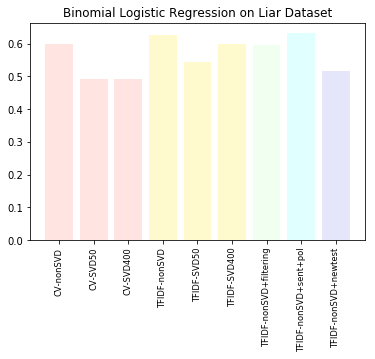

In [43]:
# plotting the results nicely
results = dict({"CV-nonSVD": 0.59956, "CV-SVD50": 0.49234, "CV-SVD400": 0.49234, "TFIDF-nonSVD" : 0.62801, 
                "TFIDF-SVD50": 0.54486, "TFIDF-SVD400": 0.59956, "TFIDF-nonSVD+filtering": 0.59737, 
                "TFIDF-nonSVD+sent+pol": 0.63238, "TFIDF-nonSVD+newtest": 0.51659})


plt.bar(range(0, len(results)), list(results.values()), align='center', 
       color = ['mistyrose', 'mistyrose', 'mistyrose', 'lemonchiffon', 'lemonchiffon',
                'lemonchiffon', 'honeydew', 'lightcyan', 'lavender'])
plt.xticks(range(len(results)), list(results.keys()), size='small', rotation = 'vertical')
plt.title('Binomial Logistic Regression on Liar Dataset')

plt.show()

### Conclusion
> As seen in the bar chart above, our best model is the Tfidf + sentiment + politics, which is tightly followed by our normal nonSVD Tfidf model. On the basis of that, we would recommend using the normal nonSVD Tfidf model, as it gives almost similar results, with less preprocessing beforhand. However, our conclusion is not really definitive, as there are important limitations to our model:
- Our training data was really sparse, and therefore our model is not scalable over different datasets.
- Our accuracy is relatively low, meaning almost the same results could be achieved by just 'guessing' the truth-value of a statement. 

> However, it was interesting and informative to learn the process behind fake news detection and how to implement and better the models. 